In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import joblib

import os
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import pathlib
DATA_DIR = pathlib.Path.cwd()/'data/input'
OUT_DIR = pathlib.Path.cwd()/'data/output'

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from utils.misc_utils import  rmspe


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
final_training_data = pd.read_pickle(OUT_DIR/'final_training_data.pkl')
final_test_data = pd.read_pickle(OUT_DIR/'final_test_data.pkl')

final_training_data = final_training_data.fillna(0)

In [21]:
final_training_data.head()

,id,time_id,stock_id,target,wap1_mean_0_150,wap1_std_0_150,wap1_fullrange_0_150,wap2_mean_0_150,wap2_std_0_150,wap2_fullrange_0_150,...,log_return_1_realized_volatility_std_stock_450_600,log_return_2_realized_volatility_std_stock_450_600,log_return_1_sum_std_stock_450_600,log_return_2_sum_std_stock_450_600,volume_mean_mean_stock_450_600,volume_mean_std_stock_450_600,price_mean_mean_stock_450_600,price_mean_std_stock_450_600,order_count_mean_mean_stock_450_600,order_count_mean_std_stock_450_600
0,0-1000,1000,0,0.001348,0.999539,0.000205,0.000656,0.999364,0.000275,0.000888,...,0.00169,0.002308,0.001489,0.001567,102.028183,76.036385,0.992722,0.085295,3.241202,1.650983
1,0-10000,10000,0,0.001805,0.999594,0.000187,0.000770,0.999544,0.000312,0.001094,...,0.00169,0.002308,0.001489,0.001567,102.028183,76.036385,0.992722,0.085295,3.241202,1.650983
2,0-10005,10005,0,0.007544,0.998943,0.001228,0.003743,0.999235,0.001282,0.004603,...,0.00169,0.002308,0.001489,0.001567,102.028183,76.036385,0.992722,0.085295,3.241202,1.650983
3,0-10017,10017,0,0.011218,0.992131,0.000387,0.001982,0.992000,0.000382,0.002315,...,0.00169,0.002308,0.001489,0.001567,102.028183,76.036385,0.992722,0.085295,3.241202,1.650983
4,0-10030,10030,0,0.002854,0.999619,0.000203,0.000799,0.999679,0.000359,0.001659,...,0.00169,0.002308,0.001489,0.001567,102.028183,76.036385,0.992722,0.085295,3.241202,1.650983


In [22]:
final_test_data.head()

,id,time_id,stock_id,wap1_mean_0_150,wap1_std_0_150,wap1_fullrange_0_150,wap2_mean_0_150,wap2_std_0_150,wap2_fullrange_0_150,log_return_1_fullrange_0_150,...,log_return_1_realized_volatility_std_stock_450_600,log_return_2_realized_volatility_std_stock_450_600,log_return_1_sum_std_stock_450_600,log_return_2_sum_std_stock_450_600,volume_mean_mean_stock_450_600,volume_mean_std_stock_450_600,price_mean_mean_stock_450_600,price_mean_std_stock_450_600,order_count_mean_mean_stock_450_600,order_count_mean_std_stock_450_600
0,0-4,4,0,1.000405,0.00017,0.000294,1.00055,0.000153,0.000277,0.000294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Building Simple FFNN

In [319]:
stock_embedding_size = 20
dense_layer_size = [32, 8]

cat_input = ['stock_id']
num_input = list(final_training_data.drop(['id', 'time_id', 'stock_id', 'target'], axis=1).columns)
num_input = [col for col in final_training_data.columns if 'return' in col]

def create_nn(
    stock_embedding_size = 20,
    dense_layer_size = [32, 16, 8],
    cat_input = cat_input,
    num_input =num_input
    ):
    cat_input_layer = keras.layers.Input(shape=(len(cat_input), ), name='cat_input')
    cat_embedded = keras.layers.Embedding(
        input_dim = np.max(final_training_data['stock_id'].values)+1,
        output_dim = stock_embedding_size,  
        input_length=len(cat_input), 
        name='stock_embedding')(cat_input_layer)
    cat_embedded = keras.layers.Flatten()(cat_embedded)

    num_input_layer = keras.layers.Input(shape=(len(num_input),), name='num_input')
    num_norm= keras.layers.BatchNormalization()(num_input_layer)
    #um_dense = keras.layers.Dense(50, activation='selu')(num_input_layer)

    input_dense = keras.layers.Concatenate(axis=1)([cat_embedded, num_norm])
    input_dense = keras.layers.BatchNormalization()(input_dense)

    for size in dense_layer_size:
        input_dense = keras.layers.Dense(size, activation='selu')(input_dense)
        input_dense = keras.layers.BatchNormalization()(input_dense)

    output_layer = keras.layers.Dense(1, activation='linear', name='prediction')(input_dense)
    
    model = keras.Model(
    inputs = [cat_input_layer, num_input_layer], 
    outputs = output_layer
    )   
    
    return model

In [320]:
model = create_nn()

def _rmspe_loss(y_true, y_pred):
    return  (K.sqrt(K.mean(K.square((y_true - y_pred) / y_true), axis=-1)))

model.compile(
    keras.optimizers.Adam(
        learning_rate=0.001,
        clipnorm=2
        ),
    loss= _rmspe_loss,
    metrics=['MSE'],
)

In [321]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
stock_embedding (Embedding)     (None, 1, 20)        2540        cat_input[0][0]                  
__________________________________________________________________________________________________
num_input (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
flatten_34 (Flatten)            (None, 20)           0           stock_embedding[0][0]            
___________________________________________________________________________________________

In [322]:
X_train, X_test, y_train, y_test = train_test_split(final_training_data[cat_input + num_input], final_training_data['target'])

In [323]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
splits = [dev_index for dev_index in kfold.split(final_training_data.index)]

In [324]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-05, patience=10, verbose=1,
    mode='min')

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1,
    mode='min')

In [325]:
model.fit([X_train[cat_input], X_train[num_input]], 
          y_train, 
          batch_size=1024,
          epochs=100,
          validation_data=([X_test[cat_input], X_test[num_input]], y_test),
          callbacks=[es, plateau],
          shuffle=True,
          verbose = 1)

Epoch 1/100
315/315 [==============================] - 4s 6ms/step - loss: 39.4012 - MSE: 0.0904 - val_loss: 9.8507 - val_MSE: 7.4895e-04
Epoch 2/100
315/315 [==============================] - 2s 5ms/step - loss: 1.8624 - MSE: 1.1226e-04 - val_loss: 2.2959 - val_MSE: 7.5770e-05
Epoch 3/100
315/315 [==============================] - 2s 5ms/step - loss: 1.1648 - MSE: 3.7613e-05 - val_loss: 3.5437 - val_MSE: 2.0717e-04
Epoch 4/100
315/315 [==============================] - 2s 5ms/step - loss: 1.0880 - MSE: 2.6142e-05 - val_loss: 1.4017 - val_MSE: 3.6439e-05
Epoch 5/100
315/315 [==============================] - 2s 5ms/step - loss: 0.8988 - MSE: 1.4946e-05 - val_loss: 1.0027 - val_MSE: 1.4260e-05
Epoch 6/100
315/315 [==============================] - 2s 5ms/step - loss: 0.8357 - MSE: 1.2985e-05 - val_loss: 1.1659 - val_MSE: 1.9801e-05
Epoch 7/100
315/315 [==============================] - 2s 5ms/step - loss: 0.7529 - MSE: 9.9880e-06 - val_loss: 1.1025 - val_MSE: 1.4666e-05
Epoch 8/100
315/

In [326]:
rmspe(y_test, model.predict([X_test[cat_input], X_test[num_input]]).reshape(-1))

0.2682845357245359

In [327]:
rmspe(y_train, model.predict([X_train[cat_input], X_train[num_input]]).reshape(-1))

0.2715106469192241

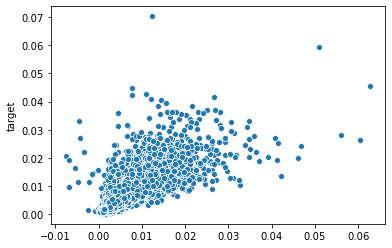

In [328]:
import seaborn as sns
sns.scatterplot(model.predict([X_test[cat_input], X_test[num_input]]).reshape(-1), y_test)